In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import shap
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load the data
data = pd.read_csv(r"C:\Users\nikhi\Desktop\Durham College\Data Sem1\Data Analysis Tools Analytics\FInal Project\5.urldata.csv")
data.head()

,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,Label
0,graphicriver.net,0,0,1,1,0,0,0,0,0,1,1,1,0,0,1,0,0
1,ecnavi.jp,0,0,1,1,1,0,0,0,0,1,1,1,0,0,1,0,0
2,hubpages.com,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0
3,extratorrent.cc,0,0,1,3,0,0,0,0,0,1,0,1,0,0,1,0,0
4,icicibank.com,0,0,1,3,0,0,0,0,0,1,0,1,0,0,1,0,0


In [6]:
#Checking the shape of the dataset
data.shape

(10000, 18)

In [7]:
#Information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Domain         10000 non-null  object
 1   Have_IP        10000 non-null  int64 
 2   Have_At        10000 non-null  int64 
 3   URL_Length     10000 non-null  int64 
 4   URL_Depth      10000 non-null  int64 
 5   Redirection    10000 non-null  int64 
 6   https_Domain   10000 non-null  int64 
 7   TinyURL        10000 non-null  int64 
 8   Prefix/Suffix  10000 non-null  int64 
 9   DNS_Record     10000 non-null  int64 
 10  Web_Traffic    10000 non-null  int64 
 11  Domain_Age     10000 non-null  int64 
 12  Domain_End     10000 non-null  int64 
 13  iFrame         10000 non-null  int64 
 14  Mouse_Over     10000 non-null  int64 
 15  Right_Click    10000 non-null  int64 
 16  Web_Forwards   10000 non-null  int64 
 17  Label          10000 non-null  int64 
dtypes: int64(17), object(1)
mem

In [3]:
# Data Preprocessing
# Check for missing values
print("Missing values in the dataset:\n", data.isnull().sum())

Missing values in the dataset:
 Domain           0
Have_IP          0
Have_At          0
URL_Length       0
URL_Depth        0
Redirection      0
https_Domain     0
TinyURL          0
Prefix/Suffix    0
DNS_Record       0
Web_Traffic      0
Domain_Age       0
Domain_End       0
iFrame           0
Mouse_Over       0
Right_Click      0
Web_Forwards     0
Label            0
dtype: int64


In [8]:
# Encode 'Domain' feature
label_encoder = LabelEncoder()
data['Domain'] = label_encoder.fit_transform(data['Domain'])

In [9]:
# Feature Engineering: Adding Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(data.drop(columns=['Label']))
poly_feature_names = poly.get_feature_names_out(data.drop(columns=['Label']).columns)
poly_data = pd.DataFrame(poly_features, columns=poly_feature_names)
poly_data['Label'] = data['Label']

In [10]:
# Splitting the data into training and testing sets
X = poly_data.drop(columns=['Label'])
y = poly_data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

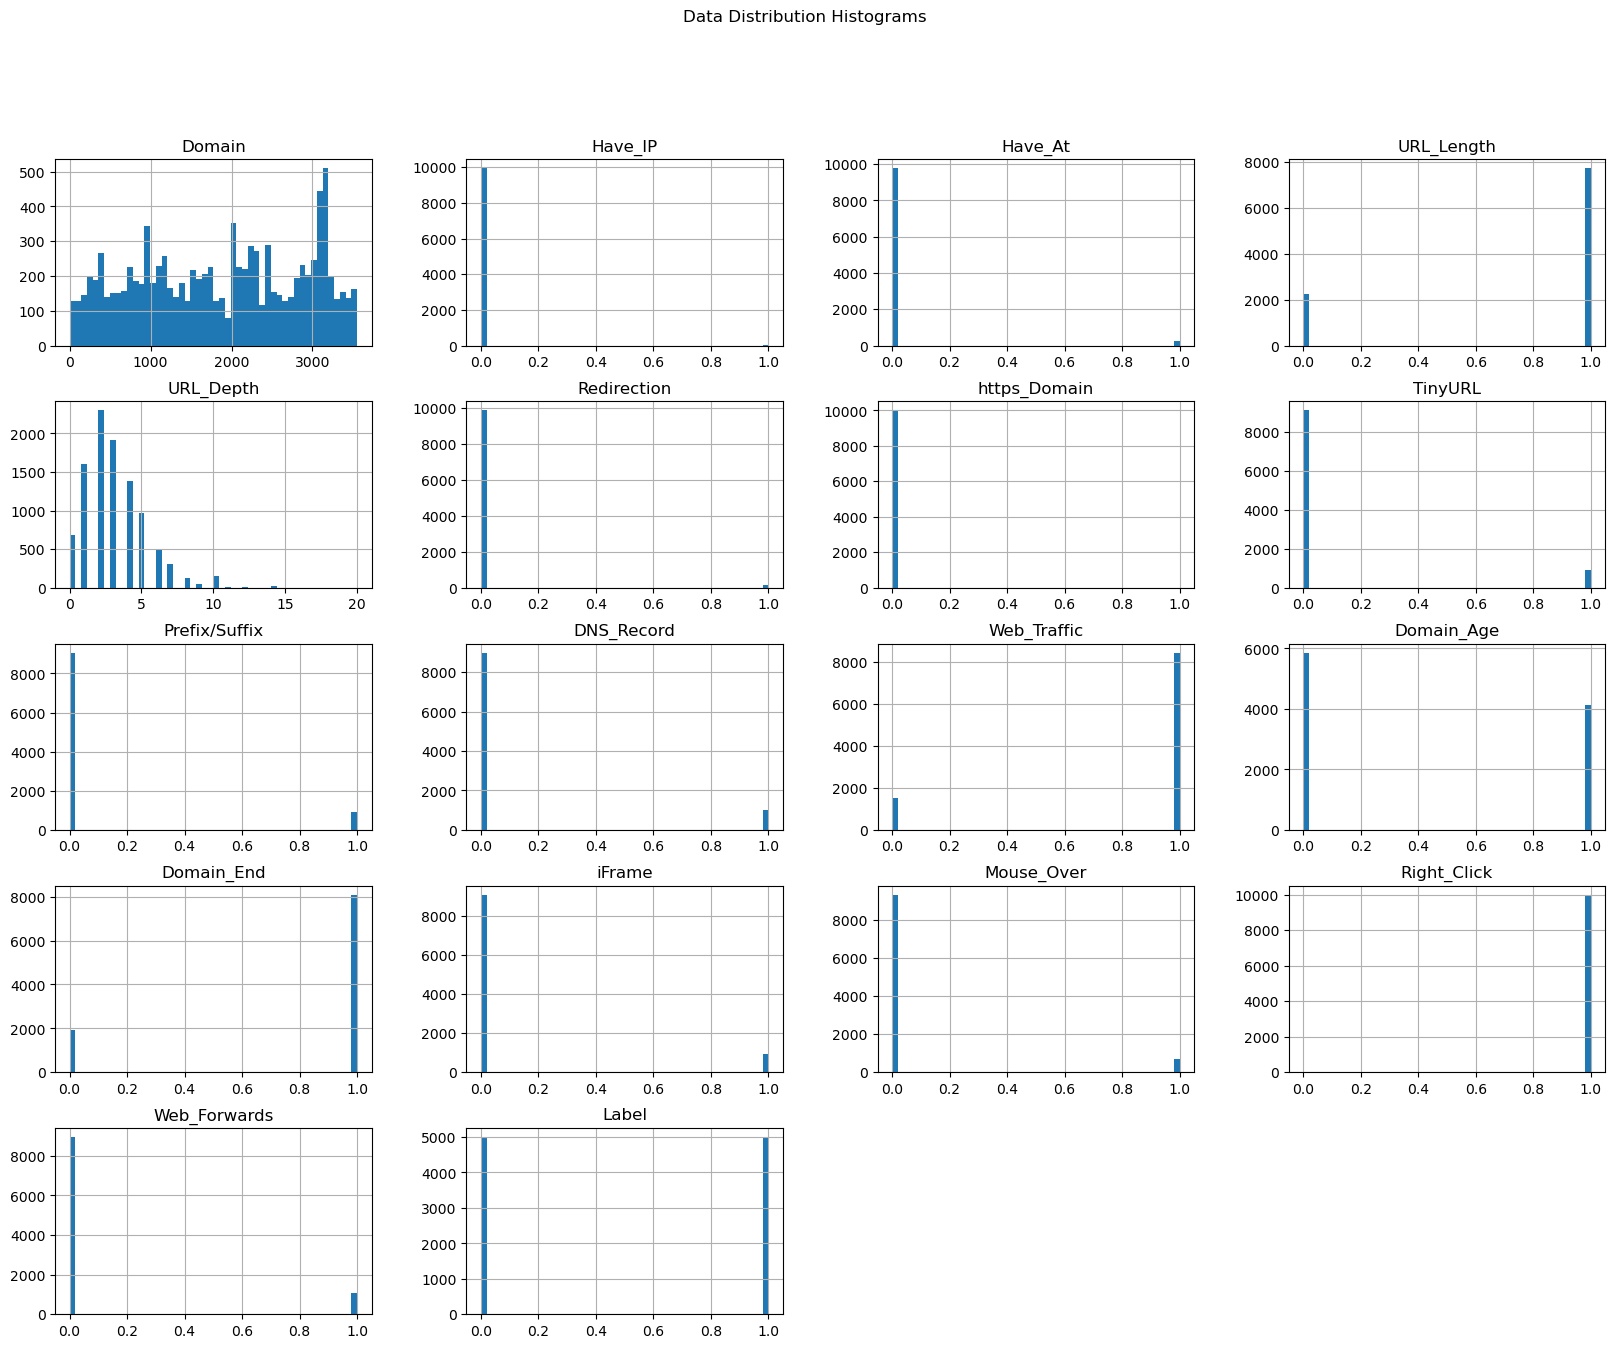

In [11]:
# Exploratory Data Analysis (EDA)
# Data distribution histograms
data.hist(bins=50, figsize=(20, 15))
plt.suptitle('Data Distribution Histograms')
plt.show()

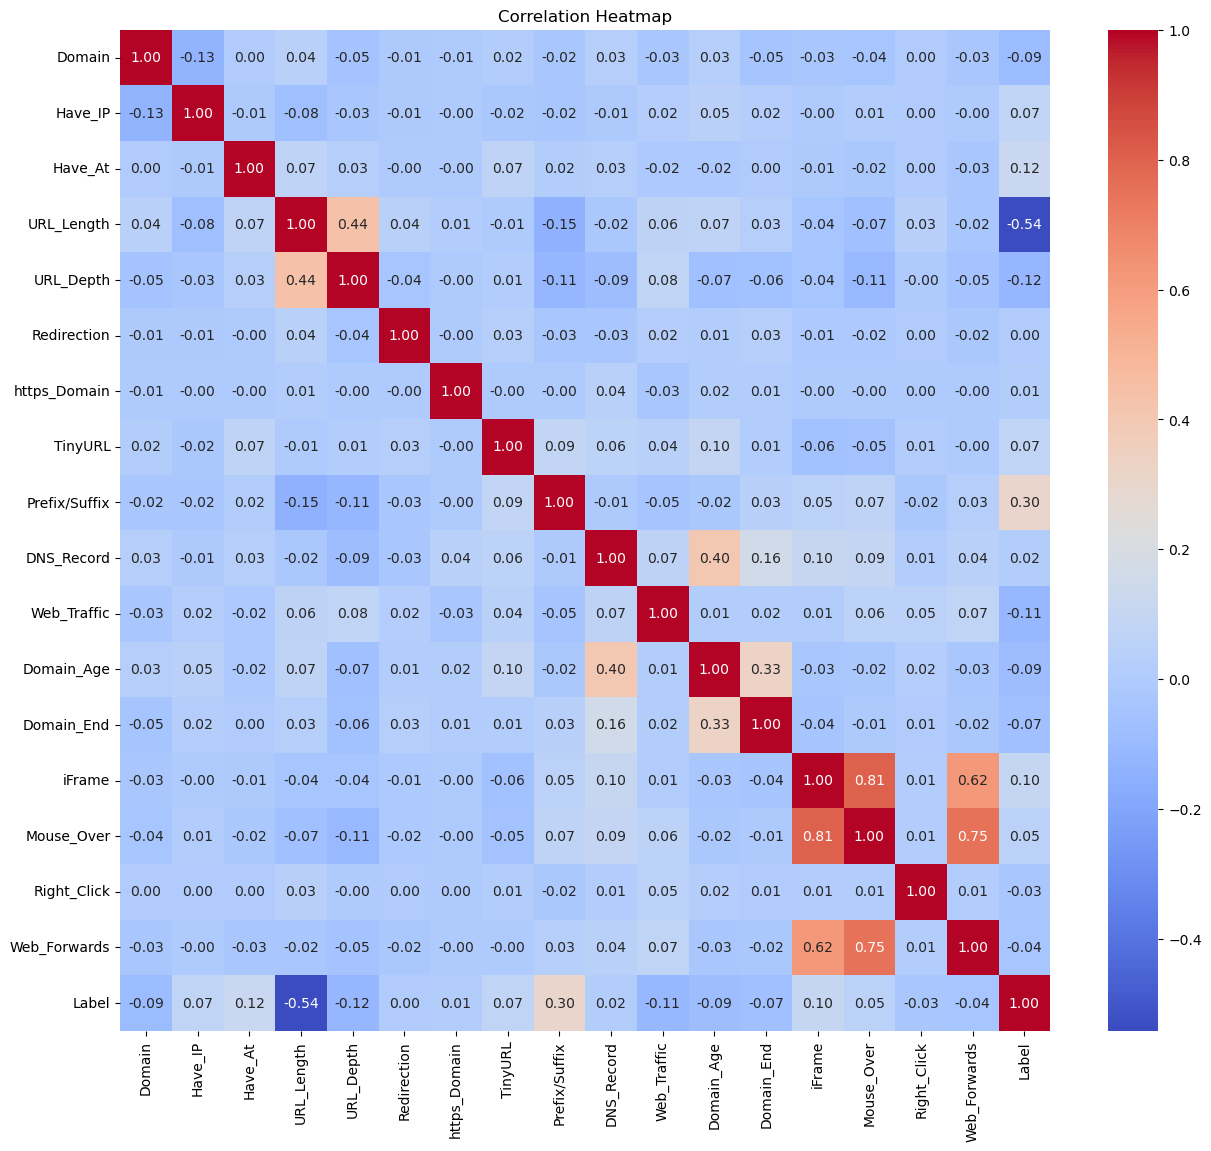

In [12]:
# Correlation heatmap
plt.figure(figsize=(15,13))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

In [13]:
# Model Training and Evaluation with Cross-Validation

# 1. Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
y_prob_nb = nb_model.predict_proba(X_test)[:, 1]
print("Naive Bayes Accuracy: ", accuracy_score(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))
nb_cv_score = cross_val_score(nb_model, X_train, y_train, cv=5, scoring='accuracy').mean()
print(f'Naive Bayes Cross-Validated Accuracy: {nb_cv_score:.4f}\n')

Naive Bayes Accuracy:  0.7946666666666666
[[1521   16]
 [ 600  863]]
              precision    recall  f1-score   support

           0       0.72      0.99      0.83      1537
           1       0.98      0.59      0.74      1463

    accuracy                           0.79      3000
   macro avg       0.85      0.79      0.78      3000
weighted avg       0.85      0.79      0.79      3000

Naive Bayes Cross-Validated Accuracy: 0.7907



In [14]:
# 2. Logistic Regression with Hyperparameter Tuning
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])

lr_param_grid = {'lr__C': [0.01, 0.1, 1, 10, 100]}
lr_grid_search = GridSearchCV(lr_pipeline, lr_param_grid, cv=5, scoring='accuracy')
lr_grid_search.fit(X_train, y_train)
y_pred_lr = lr_grid_search.predict(X_test)
y_prob_lr = lr_grid_search.predict_proba(X_test)[:, 1]
print("Logistic Regression Accuracy: ", accuracy_score(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print(f'Best Logistic Regression Parameters: {lr_grid_search.best_params_}')
lr_cv_score = cross_val_score(lr_grid_search.best_estimator_, X_train, y_train, cv=5, scoring='accuracy').mean()
print(f'Logistic Regression Cross-Validated Accuracy: {lr_cv_score:.4f}\n')

Logistic Regression Accuracy:  0.842
[[1480   57]
 [ 417 1046]]
              precision    recall  f1-score   support

           0       0.78      0.96      0.86      1537
           1       0.95      0.71      0.82      1463

    accuracy                           0.84      3000
   macro avg       0.86      0.84      0.84      3000
weighted avg       0.86      0.84      0.84      3000

Best Logistic Regression Parameters: {'lr__C': 100}
Logistic Regression Cross-Validated Accuracy: 0.8431



In [15]:
# 3. Neural Network (MLPClassifier) with Hyperparameter Tuning
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=1000, random_state=42))
])

mlp_param_grid = {
    'mlp__hidden_layer_sizes': [(50,50), (100,), (50,50,50)],
    'mlp__alpha': [0.0001, 0.001, 0.01],
}
mlp_grid_search = GridSearchCV(mlp_pipeline, mlp_param_grid, cv=5, scoring='accuracy')
mlp_grid_search.fit(X_train, y_train)
y_pred_mlp = mlp_grid_search.predict(X_test)
y_prob_mlp = mlp_grid_search.predict_proba(X_test)[:, 1]
print("Neural Network Accuracy: ", accuracy_score(y_test, y_pred_mlp))
print(confusion_matrix(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))
print(f'Best Neural Network Parameters: {mlp_grid_search.best_params_}')
mlp_cv_score = cross_val_score(mlp_grid_search.best_estimator_, X_train, y_train, cv=5, scoring='accuracy').mean()
print(f'Neural Network Cross-Validated Accuracy: {mlp_cv_score:.4f}\n')

Neural Network Accuracy:  0.9106666666666666
[[1474   63]
 [ 205 1258]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1537
           1       0.95      0.86      0.90      1463

    accuracy                           0.91      3000
   macro avg       0.92      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000

Best Neural Network Parameters: {'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (50, 50, 50)}
Neural Network Cross-Validated Accuracy: 0.9047



In [16]:
# 4. Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
print("Random Forest Accuracy: ", accuracy_score(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
rf_cv_score = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy').mean()
print(f'Random Forest Cross-Validated Accuracy: {rf_cv_score:.4f}\n')

Random Forest Accuracy:  0.9613333333333334
[[1503   34]
 [  82 1381]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1537
           1       0.98      0.94      0.96      1463

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000

Random Forest Cross-Validated Accuracy: 0.9561



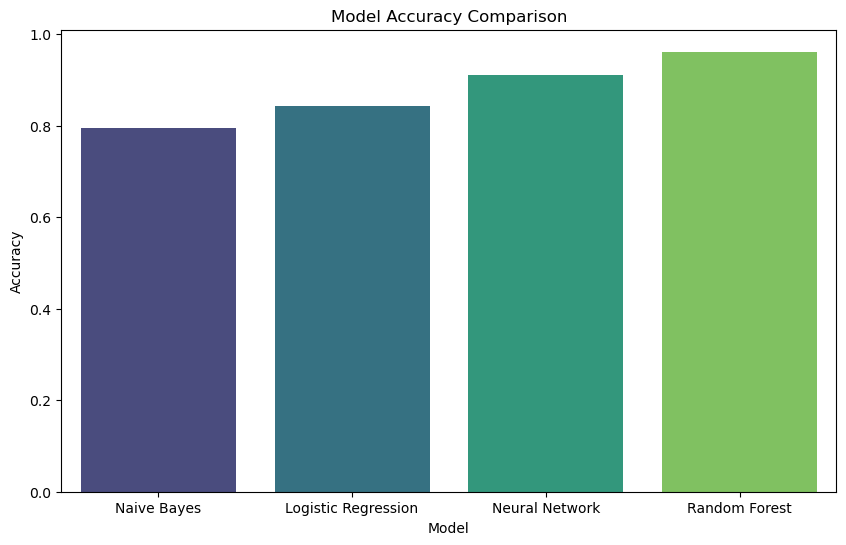

In [17]:
# Visualizing the results

# Accuracy comparison
models = ['Naive Bayes', 'Logistic Regression', 'Neural Network', 'Random Forest']
accuracies = [accuracy_score(y_test, y_pred_nb), accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_mlp), accuracy_score(y_test, y_pred_rf)]

plt.figure(figsize=(10,6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()

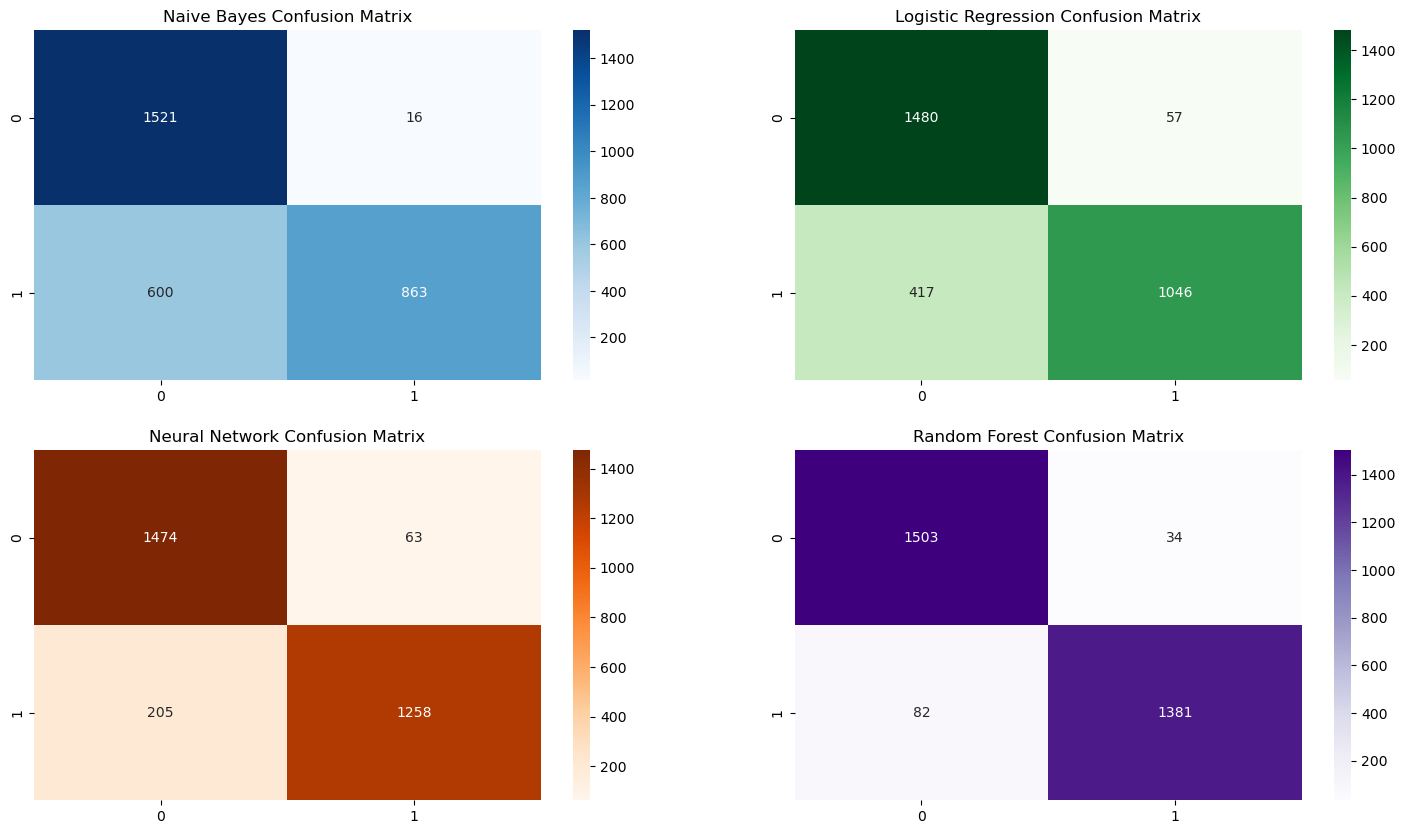

In [18]:
# Confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Naive Bayes Confusion Matrix')

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Greens', ax=axes[0,1])
axes[0,1].set_title('Logistic Regression Confusion Matrix')

sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap='Oranges', ax=axes[1,0])
axes[1,0].set_title('Neural Network Confusion Matrix')

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Purples', ax=axes[1,1])
axes[1,1].set_title('Random Forest Confusion Matrix')

plt.show()

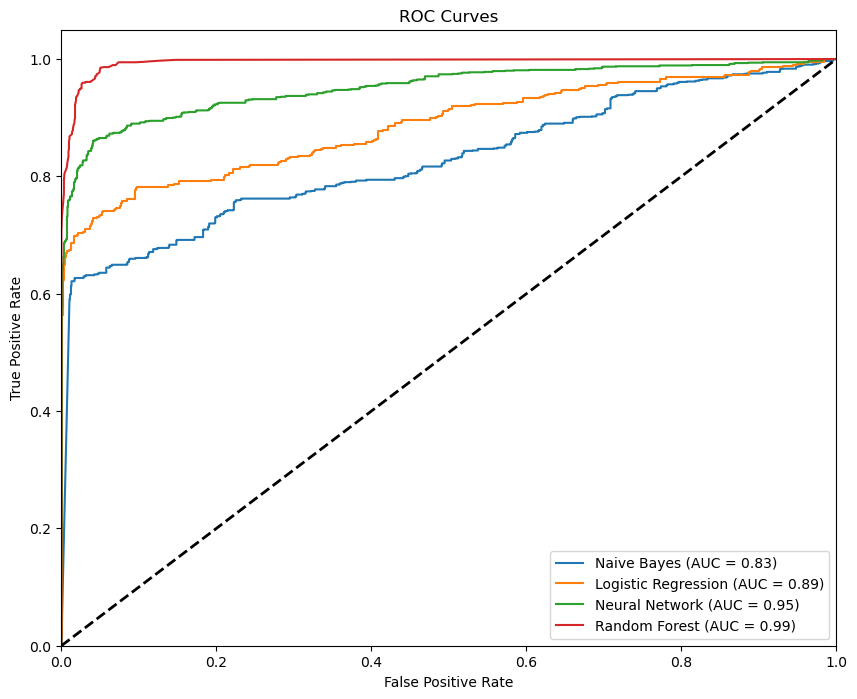

In [19]:
# ROC Curves
plt.figure(figsize=(10,8))

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_score(y_test, y_prob_nb):.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_lr):.2f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'Neural Network (AUC = {roc_auc_score(y_test, y_prob_mlp):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

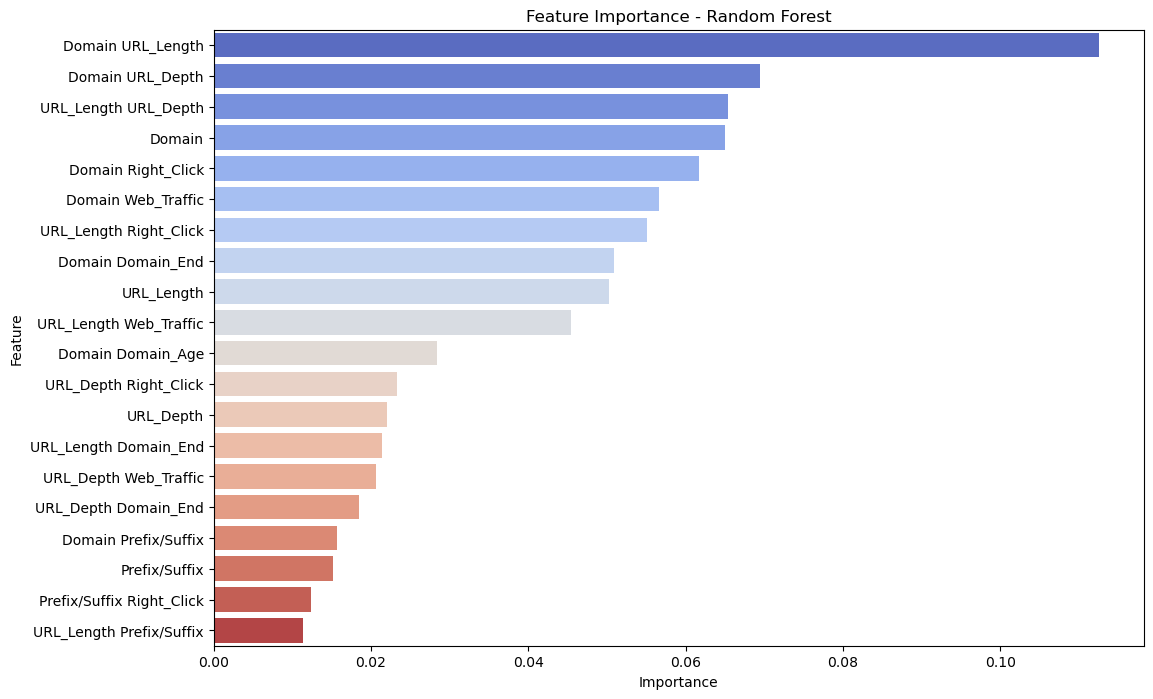

In [21]:
# Feature Importance for Random Forest
importance_rf = rf_model.feature_importances_
features_rf = poly_feature_names

# Create a DataFrame for easy manipulation
importance_df = pd.DataFrame({
    'Feature': features_rf,
    'Importance': importance_rf
})

# Set a threshold for feature importance
threshold = 0.01  # Adjust this value as needed
important_features = importance_df[importance_df['Importance'] > threshold]

# Sort features by importance
important_features = important_features.sort_values(by='Importance', ascending=False)

# Bar plot of feature importance
plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data=important_features, palette='coolwarm')
plt.title('Feature Importance - Random Forest')
plt.show()

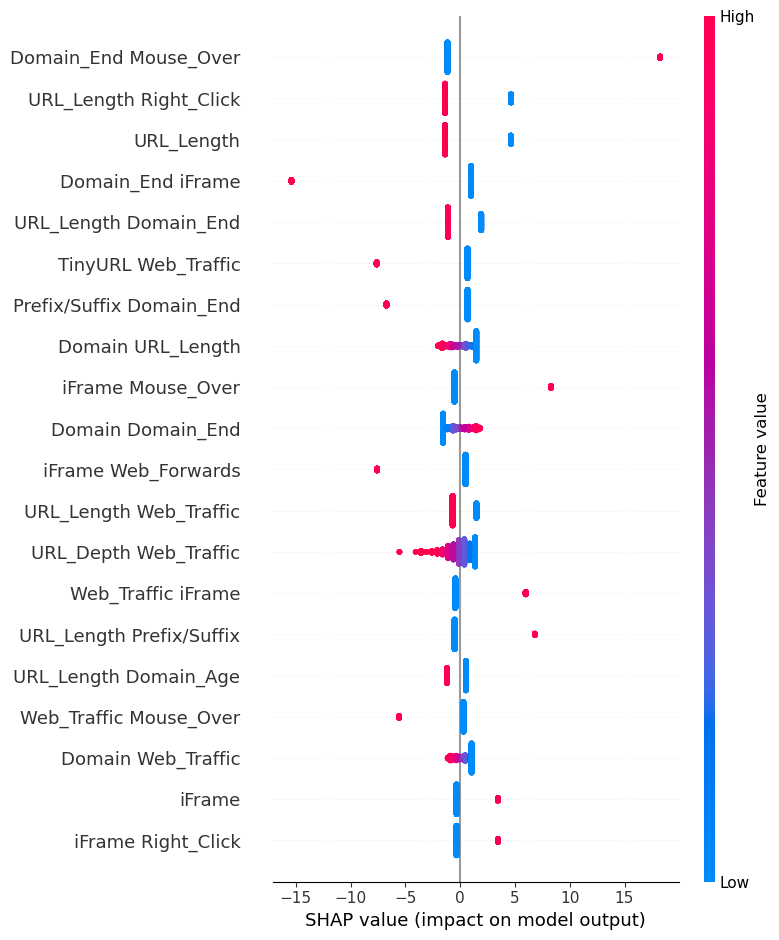

In [22]:
# Model Explainability using SHAP for Logistic Regression
explainer = shap.LinearExplainer(lr_grid_search.best_estimator_['lr'], X_train)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features_rf)
